
# Brewery Analysis: Machine Learning



---



*  Data is preprocessed and cleaned by removing unneeded columns, merging zip code/cities datasets, and limiting dataset to the top 1,000 most populated cities.
*  To obtain the best possible predictive results, preliminary features should be explored, engineered, and carefully selected. Possible preliminary features for this model could be average income per zipcode, income per capita, and clothing stores per brewery count.
*  The importance of correlation between breweries and outdoor clothing stores will drive which features will be engineered and selected, ultimately answering the hypthesis.
*  Data was split into training and testing sets using train_test_split and a random state of 24. This will assist in evaluating the performance of the model in relation to the dataset.
*  A linear regression model was chosen to best illustrate correlation between brewery location and outdoor clothing store location. Is there a strong relationship between the two? The benefits of using a linear regression is readability and abiility to answer basic questions. Limitations of a linear regression model will be sensitivity to outliers. With more time we would like to also set up a cluster model.





In [2]:
# Import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from database_connection import ENGINE

**# Test Linear Regression Model**

In [4]:

X, y = make_regression(n_samples=100, n_features=1, random_state=24, noise=20, bias=50.0)

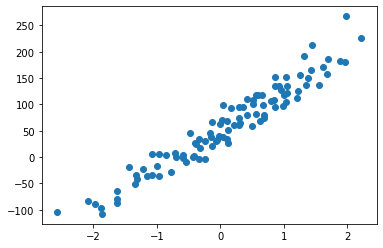

In [5]:
plt.scatter(X, y)

In [6]:
model = LinearRegression()
model

LinearRegression()

In [7]:
model.fit(X, y)
print(model)

LinearRegression()


In [8]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

Weight coefficients:  [73.68622249]
y-axis intercept:  52.35050319965709


In [9]:
predictions = model.predict(X)
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y[0]}")

True output: 51.573180999075355
Predicted output: 61.05269396989403
Prediction Error: 9.479512970818675


In [10]:
pd.DataFrame({"Predicted": predictions, "Actual": y, "Error": predictions - y})[["Predicted", "Actual", "Error"]]

,Predicted,Actual,Error
0,61.052694,51.573181,9.479513
1,116.539022,135.744467,-19.205445
2,-45.354712,-34.665692,-10.689020
3,-19.366764,6.805878,-26.172642
4,120.974797,134.426874,-13.452077
...,...,...,...
95,111.587291,106.903818,4.683473
96,96.719525,118.261070,-21.541545
97,191.563874,181.988316,9.575558
98,21.512531,3.015834,18.496697


# Data Selection

In [3]:
# Connect to needed databases 
# Connect to zip codes - cleaned database

zip_codes_cleaned_query = '''
    SELECT *
    FROM zip_codes_cleaned
'''

zip_codes = pd.read_sql_query(
    zip_codes_cleaned_query,
    con=ENGINE
)
# Connect to breweries database

breweries_query = '''
    SELECT *
    FROM breweries
'''

breweries = pd.read_sql_query(
    breweries_query,
    con=ENGINE
)

# Connect to outdoor clothing database

outdoor_query = '''
    SELECT *
    FROM outdoor
'''

outdoor = pd.read_sql_query(
    outdoor_query,
    con=ENGINE
)

In [4]:
zip_codes.sample(10)

,zip_code,city,state,county,latitude,longitude,irs_estimated_population
7796,28001,Albemarle,NC,Stanly County,35.36,-80.19,21510
20524,65047,Kaiser,MO,Miller County,38.13,-92.58,1100
4685,16863,Olanta,PA,Clearfield County,40.90,-78.50,620
24948,78569,Lyford,TX,Willacy County,26.41,-97.78,3510
23930,75650,Hallsville,TX,Harrison County,32.50,-94.57,9260
13219,45204,Cincinnati,OH,Hamilton County,39.11,-84.55,4240
26064,83422,Driggs,ID,Teton County,43.73,-111.22,4060
12047,41048,Hebron,KY,Boone County,39.08,-84.70,15650
16843,55313,Buffalo,MN,Wright County,45.17,-93.86,23210
28882,97080,Gresham,OR,Multnomah County,45.47,-122.37,39890


In [22]:
# Remove yelp id and closed columns from outdoor/brewery dataframe

breweries_df = breweries.drop(['yelp_id', 'is_closed'], axis=1)
outdoor_df = outdoor.drop(['yelp_id', 'is_closed'], axis=1)

In [38]:
breweries_df=breweries_df.rename(columns={"name": "brewery", "rating": "brewery_rating"})

In [80]:
breweries_df.sample(10)

,brewery,lat,lng,city,business_type,brewery_rating,zip_code,state
320,Five Cities Brewing,41.573840,-90.500410,Bettendorf,breweries,4.0,52722,IA
316,WAKE Brewing,41.508170,-90.563700,Rock Island,brewpubs,4.5,61201,IL
28,El Bait Shop,41.582979,-93.618744,Des Moines,bars,4.5,50309,IA
234,Copperhead Brewery,30.316495,-95.462627,Conroe,breweries,4.5,77301,TX
176,Ferndale Project,42.450518,-83.143062,Ferndale,coffee,4.0,48220,MI
228,Asylum Brewing,33.849727,-117.861218,Anaheim,breweries,4.0,92806,CA
49,HIGHPOINT Brewing Company,34.102534,-117.814784,San Dimas,brewpubs,4.5,91773,CA
236,"Tapped DraftHouse & Kitchen - Conroe, TX",30.224838,-95.542395,Conroe,tradamerican,4.5,77384,TX
287,Rasselbock L.A. Kitchen & Beer Garden,34.004130,-118.431020,Los Angeles,german,4.5,90066,CA
175,Michigan Beer Growler Company,42.518468,-83.223954,Beverly Hills,breweries,4.5,48025,MI


In [36]:
outdoor_df=outdoor_df.rename(columns={"name": "outdoor_store", "rating": "outdoor_rating"})

In [37]:
outdoor_df.sample(10)

,outdoor_store,lat,lng,city,business_type,outdoor_rating,zip_code,state
197,Sisu,33.913504,-117.931691,La Habra,menscloth,5.0,90631,CA
143,DICK'S Sporting Goods,33.953100,-84.231900,Norcross,sportswear,2.5,30092,GA
342,Appalachian Outfitters,41.219680,-81.492830,Peninsula,outdoorgear,3.0,44264,OH
253,Pilot Outfitters,34.014116,-118.449901,Santa Monica,outdoorgear,5.0,90405,CA
331,Northwest Outdoor Center,47.638281,-122.340328,Seattle,boating,4.5,98109,WA
339,Geiger's,41.485300,-81.798740,Lakewood,sportgoods,4.5,44107,OH
281,Big 5 Sporting Goods,34.470000,-117.247020,Apple Valley,huntingfishingsupplies,3.0,92308,CA
171,Sonoma Outfitters,38.445305,-122.686475,Santa Rosa,sportswear,3.0,95405,CA
67,Ocean Magic Surf Shop,26.932461,-80.078325,Jupiter,sportswear,4.0,33477,FL
4,The Climbing Life Guides,34.111679,-116.330658,Joshua Tree,climbing,5.0,92252,CA


In [5]:
# Connect to city_summary database
city_summary = '''
    SELECT *
    FROM city_summary
'''

city_summary_df = pd.read_sql_query(
    city_summary,
    con=ENGINE
)

city_summary_df.sample(10)

,city,state,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,num_outdoor_stores,population,ts_updated
44,Austin,TX,260397,2417,7103457,106948,46717,237611,0,0,939202,2022-08-22 05:28:06.714394+00:00
843,Smyrna,TN,270076,115097,445326,272686,206870,315469,0,0,54750,2022-08-22 05:28:06.714394+00:00
711,Porterville,CA,213283,140574,313415,201073,168894,249316,0,0,64290,2022-08-22 05:28:06.714394+00:00
393,Honolulu,HI,254936,24203,1070381,182042,121548,300442,0,0,351805,2022-08-22 05:28:06.714394+00:00
320,Frisco,TX,693784,66421,2844538,213347,164536,813611,0,0,120040,2022-08-22 05:28:06.714394+00:00
848,Southfield,MI,102017,33353,298458,91134,71350,118551,0,0,67330,2022-08-22 05:28:06.714394+00:00
574,Minneapolis,MN,166695,1495,1566230,107137,60639,185021,0,0,1001650,2022-08-22 05:28:06.714394+00:00
98,Brentwood,TN,1037804,59877,4788698,179808,135339,718539,0,0,59690,2022-08-22 05:28:06.714394+00:00
325,Gaithersburg,MD,284860,16946,2100655,167680,88282,259491,0,0,138420,2022-08-22 05:28:06.714394+00:00
55,Bay Shore,NY,354392,139076,594300,335394,280313,429026,0,0,61150,2022-08-22 05:28:06.714394+00:00


In [13]:
# sort by num_breweries and top 25 because rest of cities has not been filled yet
# This can be removed once rest of cities have been filled
city_summary_top25 = city_summary_df.sort_values(by='num_breweries', ascending=False).head(25)
city_summary_top25

,city,state,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,num_outdoor_stores,population,ts_updated
512,Louisville,KY,139141,1426,1223918,86366,42768,161692,18,12,648720,2022-08-22 05:28:06.714394+00:00
239,Des Plaines,IL,240090,61766,624247,221871,140416,293728,16,18,87190,2022-08-22 05:28:06.714394+00:00
728,Quincy,MA,217650,33467,738266,126500,98431,303616,15,18,85600,2022-08-22 05:28:06.714394+00:00
342,Goldsboro,NC,143490,76342,331255,120646,99310,165655,15,20,58075,2022-08-22 05:28:06.714394+00:00
136,Carson,CA,212034,55212,507431,160977,132312,287227,14,18,79570,2022-08-22 05:28:06.714394+00:00
138,Cartersville,GA,145371,51676,320527,124262,88690,170632,14,18,57430,2022-08-22 05:28:06.714394+00:00
411,Irvine,CA,312892,13881,2019877,113514,68676,360017,13,17,236760,2022-08-22 05:28:06.714394+00:00
530,Manassas,VA,223664,33707,672266,185866,92404,276335,12,16,146210,2022-08-22 05:28:06.714394+00:00
688,Pensacola,FL,113254,2300,546477,95842,43815,165592,12,12,220700,2022-08-22 05:28:06.714394+00:00
890,Tempe,AZ,237575,23927,919679,212583,128718,288195,11,18,129510,2022-08-22 05:28:06.714394+00:00


# Data Processing

In [40]:
# Set X and y for linear regression model
X = city_summary_top25.num_breweries.values.reshape(-1,1)
y = city_summary_top25.num_outdoor_stores.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(25, 1)
(25, 1)


In [148]:
# Transform String Columns(Onehotencoder)
# I don't think we need this for linear regression since all of our values are int
encoder = OneHotEncoder(handle_unknown='error')
encoder.fit(X)

OneHotEncoder()

In [164]:
# Scale data if needed (StandardScaler)
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

In [ ]:
brewery_scaled = data_scaler.fit(encoder)

brewery_scaled[:25]

# Data Transformation

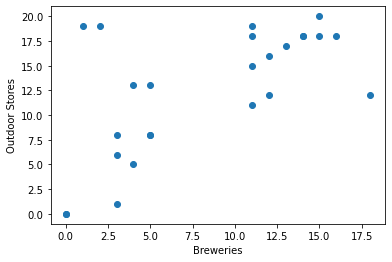

In [20]:
plt.scatter(city_summary_top25.num_breweries, city_summary_top25.num_outdoor_stores)
plt.xlabel('Breweries')
plt.ylabel('Outdoor Stores')
plt.show()

In [41]:
# Create an instance of the model(LinearRegression)
model = LinearRegression()

In [42]:
# Train the model with the dataset 
model.fit(X,y)

LinearRegression()

In [44]:
# Create predictions
y_pred = model.predict(X)
print(y_pred.shape)

(25, 1)


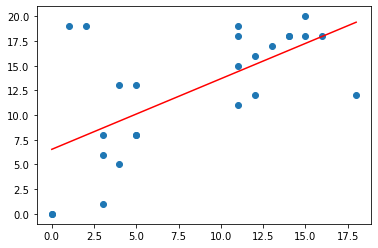

In [45]:
# Visualize trendline
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [46]:
# Find model slope and intercept
print(model.coef_)
print(model.intercept_)

[[0.71445608]]
[6.5357254]


In [47]:
# Model formula
print(f"y = {model.coef_}x + {model.intercept_}")

y = [[0.71445608]]x + [6.5357254]


In [ ]:
# Validate the model
# accuracy_score (not using accuracy for linear regression)
#acc_score = accuracy_score(y_test, predictions)

# confusion_matrix/classification_report
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

In [ ]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
# Find impact of different variables